In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [3]:
df = pd.read_csv("results_warmup.csv")
df.head()

,n,max_levels,k,cpu_ms,cublas_kernel_ms,cublas_total_ms,gpu_kernel_ms,gpu_total_ms,ops_cublas,ops_gpu,gflops_cublas,gflops_gpu,relerr_cublas,relerr_custom
0,128,2,6,0.014861,0.021372,24.512375,0.059396,0.507136,32768,14336,1.547251,0.243122,2.080000e-07,2.180000e-07
1,128,2,8,0.013337,0.022016,24.007313,0.060676,0.484868,32768,16384,1.492209,0.270950,2.050000e-07,2.250000e-07
2,128,2,10,0.012205,0.020224,21.651325,0.056448,0.476416,32768,18432,1.624227,0.327194,2.070000e-07,2.180000e-07
3,128,2,12,0.012076,0.021504,23.092850,0.060928,0.489728,32768,20480,1.537670,0.339934,2.140000e-07,2.280000e-07
4,128,2,14,0.012588,0.022528,22.956537,0.059904,0.503936,32768,22528,1.474815,0.380638,1.910000e-07,2.200000e-07


Text(0.5, 0.92, 'Execution Time vs Matrix Size and Low-Rank Approximation')

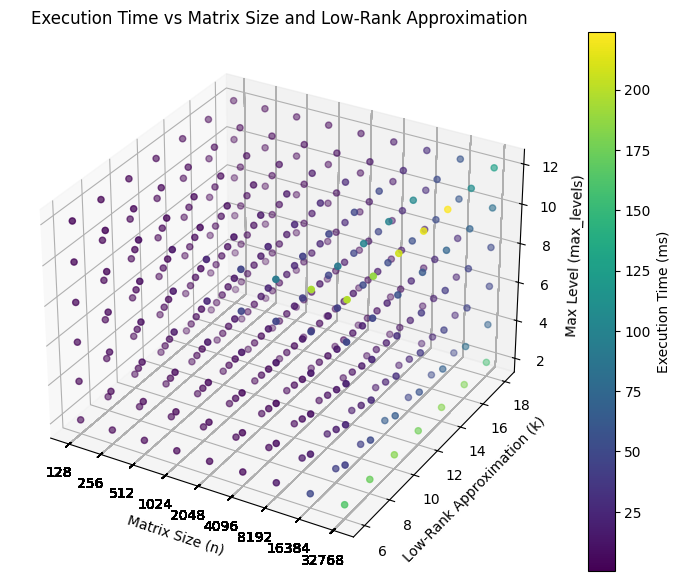

In [6]:
X = np.log10(df['n'])
Y = df['k']
Z = df['max_levels']  # Replace with 'gpu_kernel_ms' or 'gpu_total_ms' as needed

# Create a 3D scatter plot
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(X, Y, Z, c=df['gpu_total_ms'], cmap='viridis')

# Set labels
ax.set_xlabel('Matrix Size (n)')
ax.set_ylabel('Low-Rank Approximation (k)')
ax.set_zlabel('Max Level (max_levels)')

tick_positions = np.log10(df['n'])
tick_labels = df['n']
ax.set_xticks(tick_positions)
ax.set_xticklabels(tick_labels)

# Add color bar
fig.colorbar(scatter, ax=ax, label='Execution Time (ms)')

plt.title('Execution Time vs Matrix Size and Low-Rank Approximation')

Text(0.5, 0.92, 'Execution Time vs Matrix Size and Low-Rank Approximation')

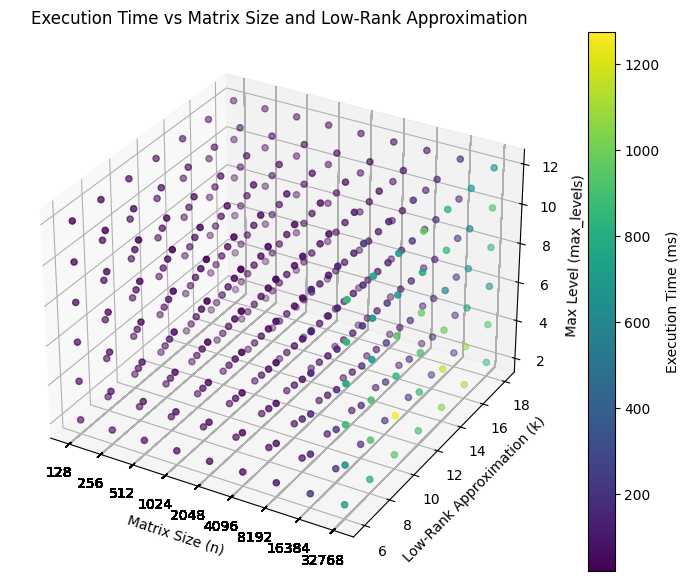

In [12]:
X = np.log10(df['n'])
Y = df['k']
Z = df['max_levels']  # Replace with 'gpu_kernel_ms' or 'gpu_total_ms' as needed

# Create a 3D scatter plot
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(X, Y, Z, c=df['cublas_total_ms'], cmap='viridis')

# Set labels
ax.set_xlabel('Matrix Size (n)')
ax.set_ylabel('Low-Rank Approximation (k)')
ax.set_zlabel('Max Level (max_levels)')

tick_positions = np.log10(df['n'])
tick_labels = df['n']
ax.set_xticks(tick_positions)
ax.set_xticklabels(tick_labels)

# Add color bar
fig.colorbar(scatter, ax=ax, label='Execution Time (ms)')

plt.title('Execution Time vs Matrix Size and Low-Rank Approximation')

In [ ]:
import statsmodels.api as sm

# Define independent variables and dependent variable
X = df[['n', 'k', 'max_levels']]
y = df['gpu_kernel_ms']

# Add a constant to the independent variables
X = sm.add_constant(X)

# Fit the regression model
model = sm.OLS(y, X).fit()

# Print the summary
print(model.summary())

NameError: name 'df' is not defined

In [ ]:
# 1) Load


# 2) Pivot GFLOP/s vs n for each k
pivot = df.pivot(index="n", columns="k", values="gflops")
pivot.plot(marker="o")
plt.title("HODLR-MVM GFLOP/s vs matrix size")
plt.xlabel("n")
plt.ylabel("GFLOP/s")
plt.xscale("log", base=2)
plt.grid(True, which="both", ls="--")
plt.legend(title="k")
plt.tight_layout()
plt.show()

# 3) Save processed summary if desired
df.to_excel("results.xlsx", index=False)